In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from src.utils.load_config import load_config 
from src.utils.misc import set_seed
import torch
import pandas as pd
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [27]:
config_file = './configs/base_config.yaml'
config = load_config(config_file)
data = pd.read_csv('./data/labels.csv', sep=';')
set_seed(config.random_seed)

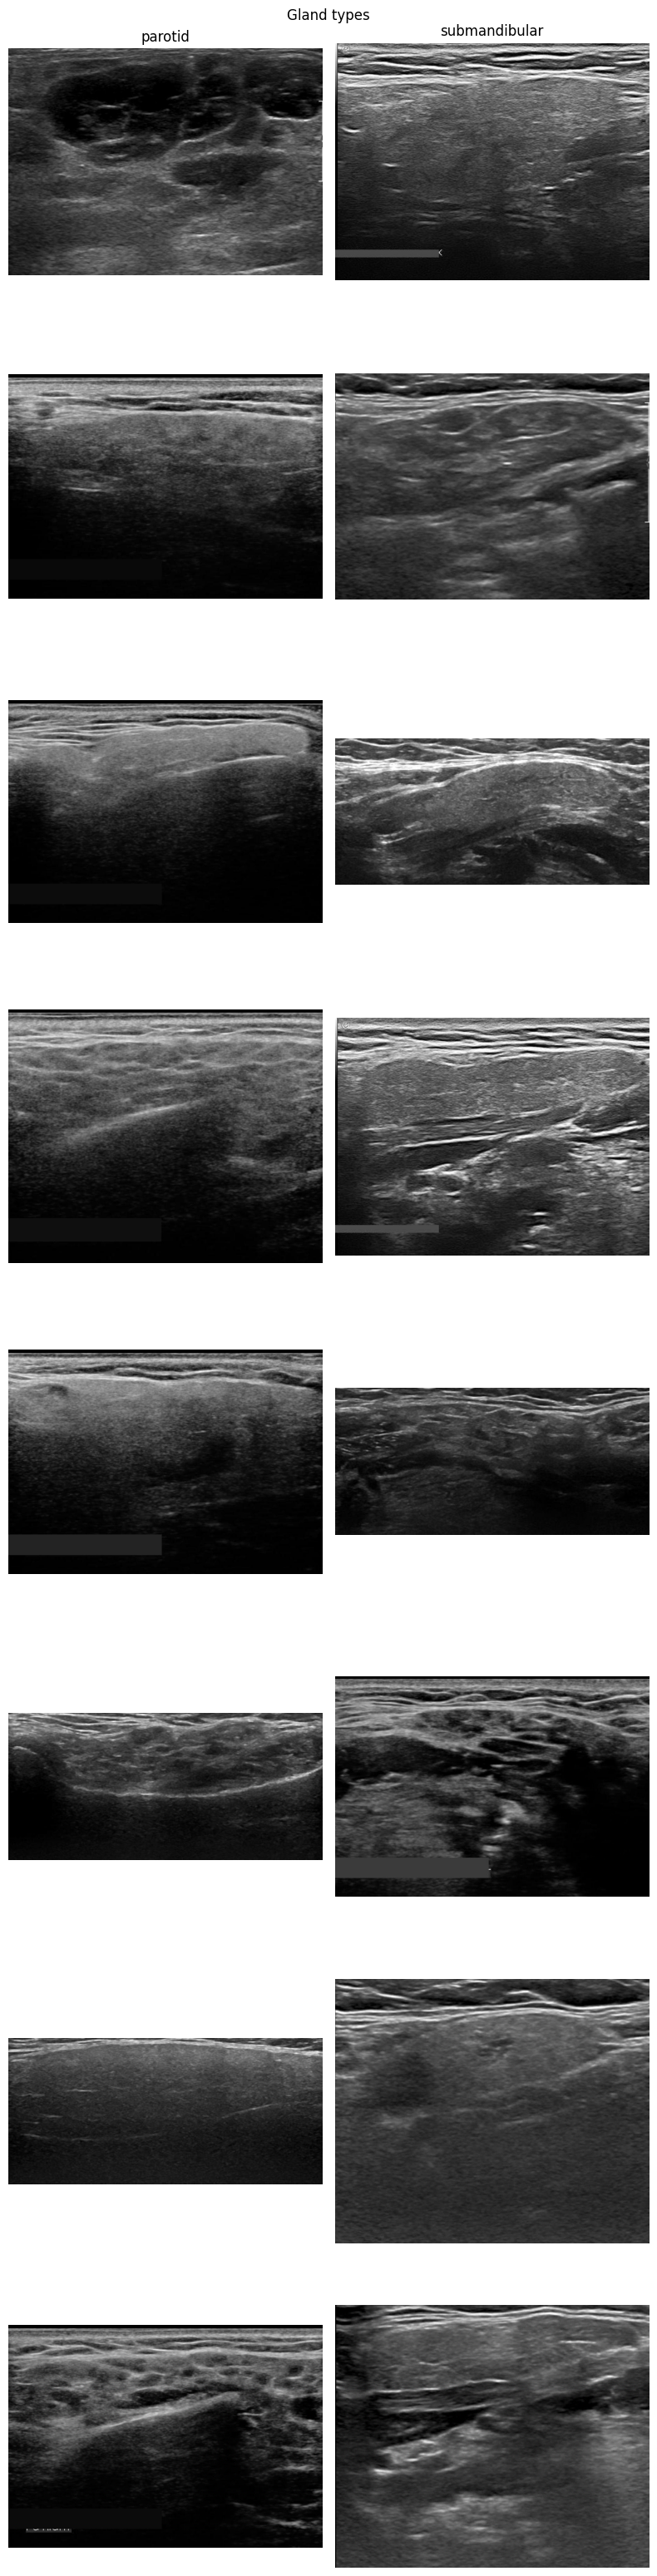

In [4]:
def plot_grid(m, n, split_key, values, filter=False, filter_key='', filter_value='', title=''):
    fig, axs = plt.subplots(m, n, figsize=(4*n, 4*m))
    for i in range(n):
        if not filter:
            rows = np.random.choice(data[data[split_key] == values[i]]['Anonymized ID'], m, replace=False)
        else:
            rows = np.random.choice(data[(data[split_key] == values[i]) & (data[filter_key] == filter_value)]['Anonymized ID'], m, replace=False)

        for j in range(m):        
            ax = axs[j][i]
            if j == 0:
                ax.set_title(str(values[i]))
            id = rows[j]
            ax.imshow(Image.open(f'./data/imgs/{id:03}.jpg'), 'grey')
            ax.axis(False)
    fig.suptitle(title)
    plt.tight_layout()
    plt.show()

n, m = 2, 8
split_key = 'parotid/submandibular'
values = ['parotid', 'submandibular']
filter = False
title = 'Gland types'

plot_grid(m, n, split_key, values, filter, title=title)

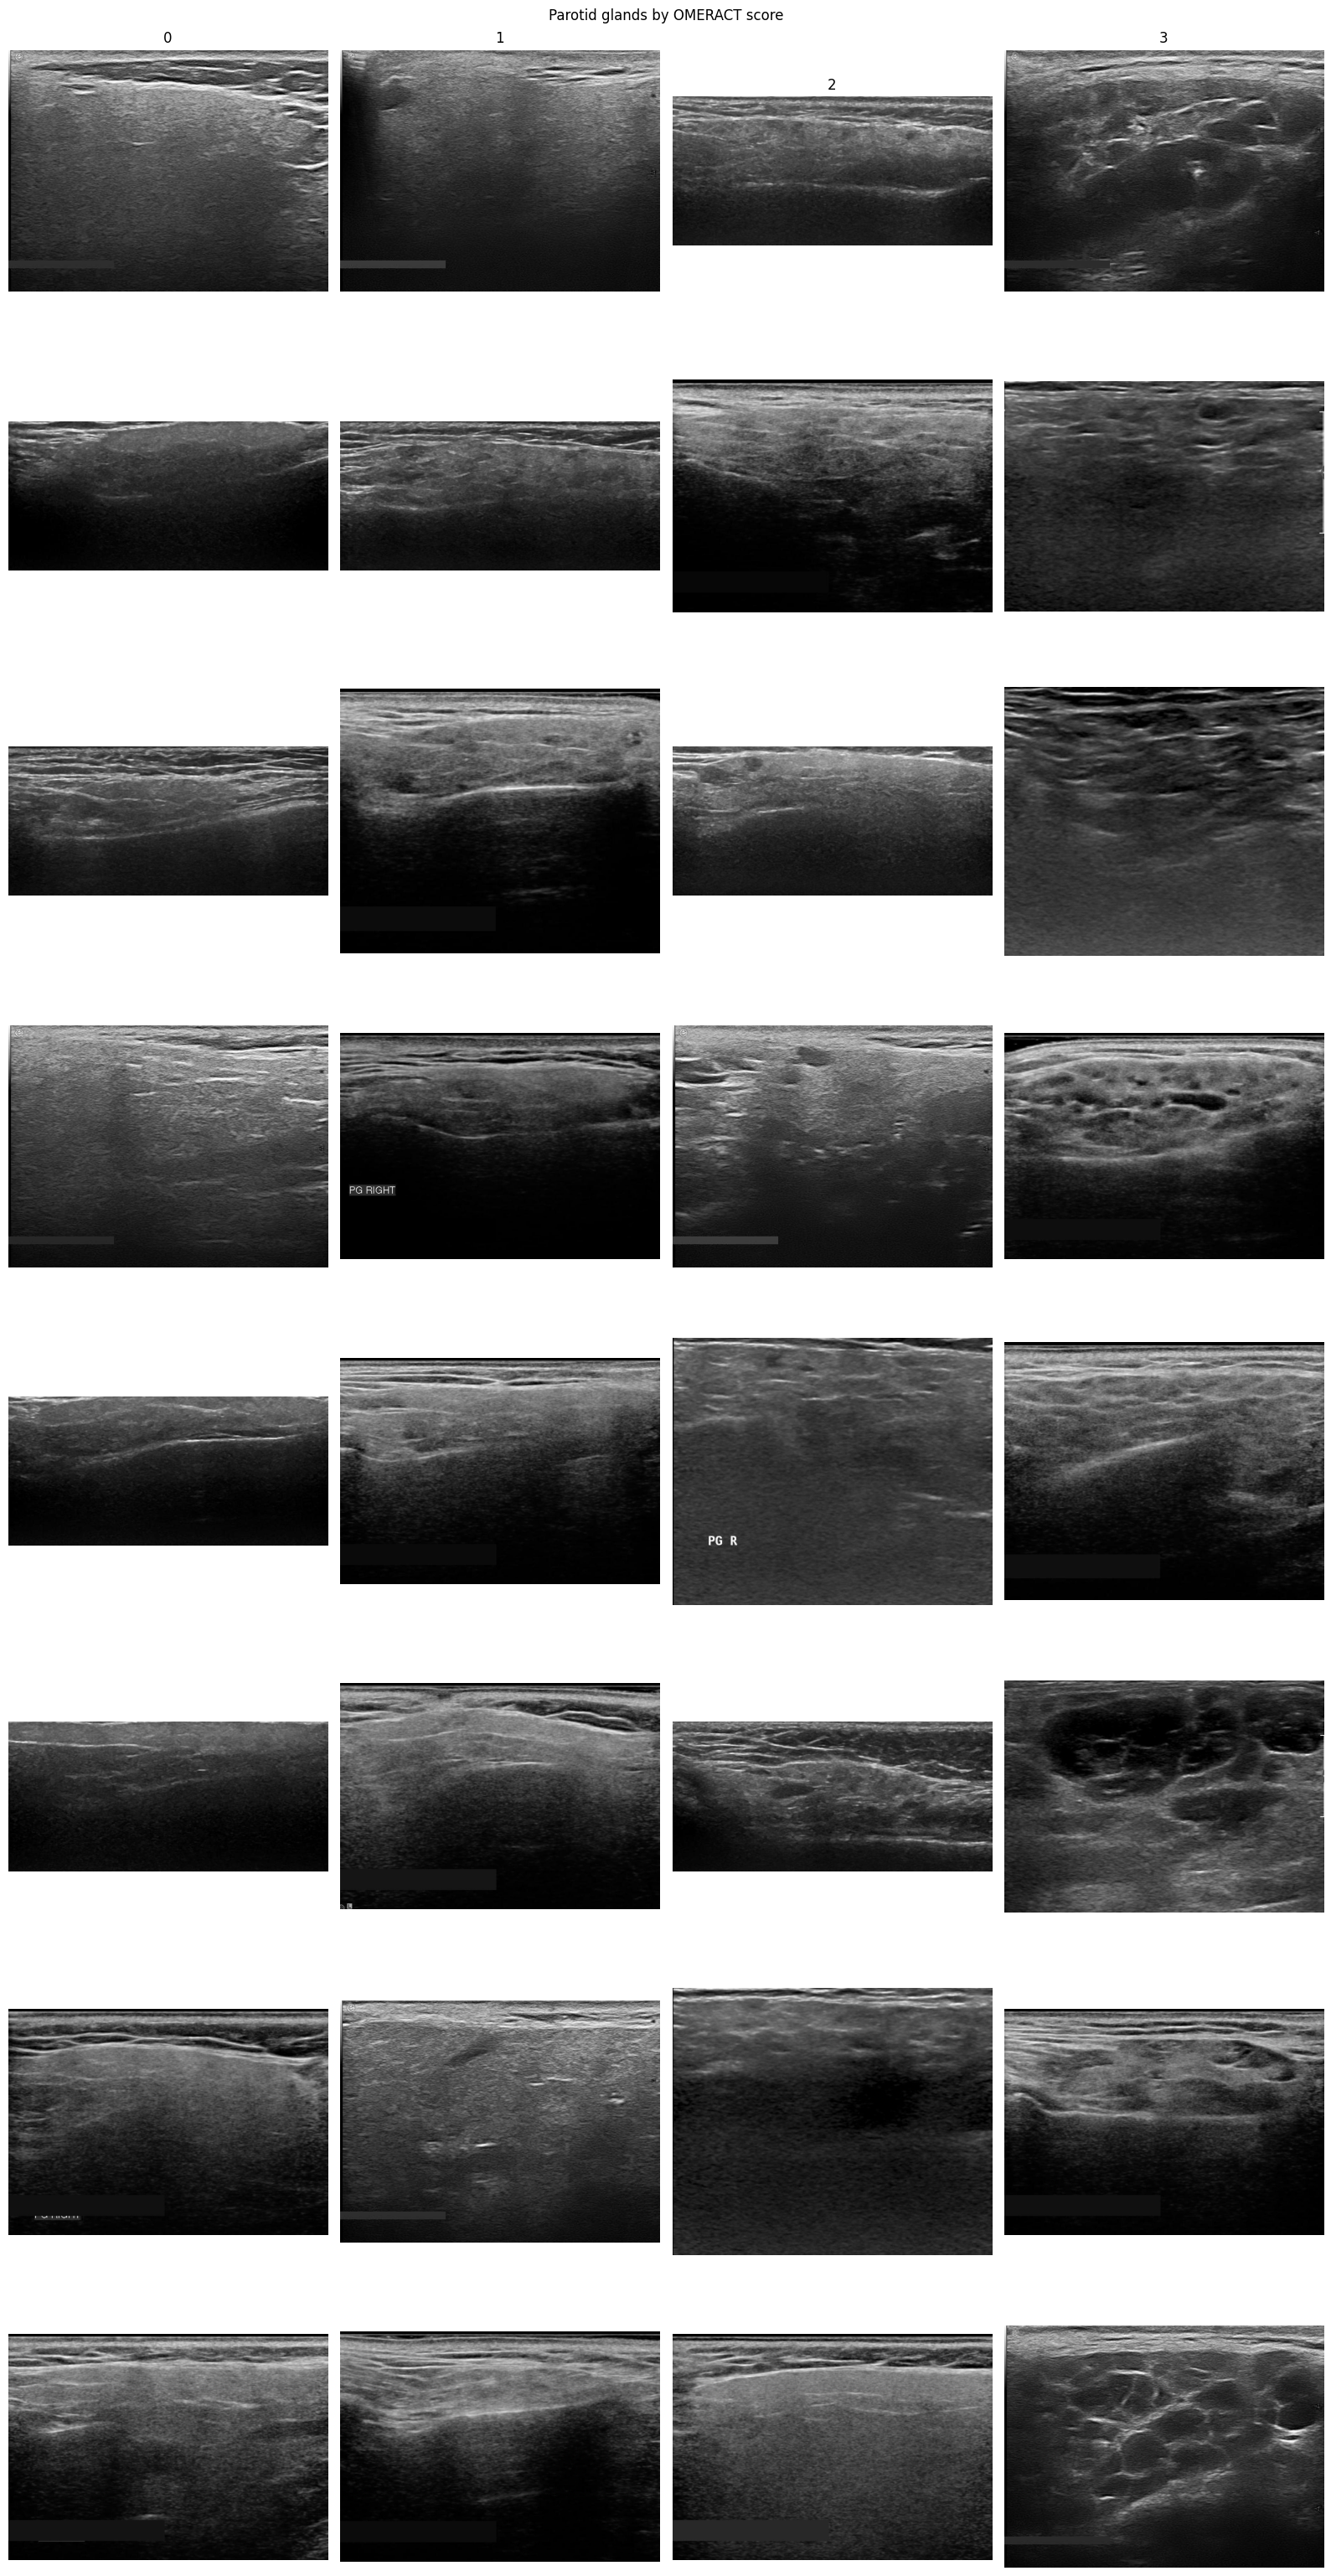

In [5]:
n, m = 4, 8
split_key = 'OMERACT score'
values = [0, 1, 2, 3]
filter = True
filter_key = 'parotid/submandibular'
filter_value = 'parotid'
title = 'Parotid glands by OMERACT score'

plot_grid(m, n, split_key, values, filter, filter_key, filter_value, title)

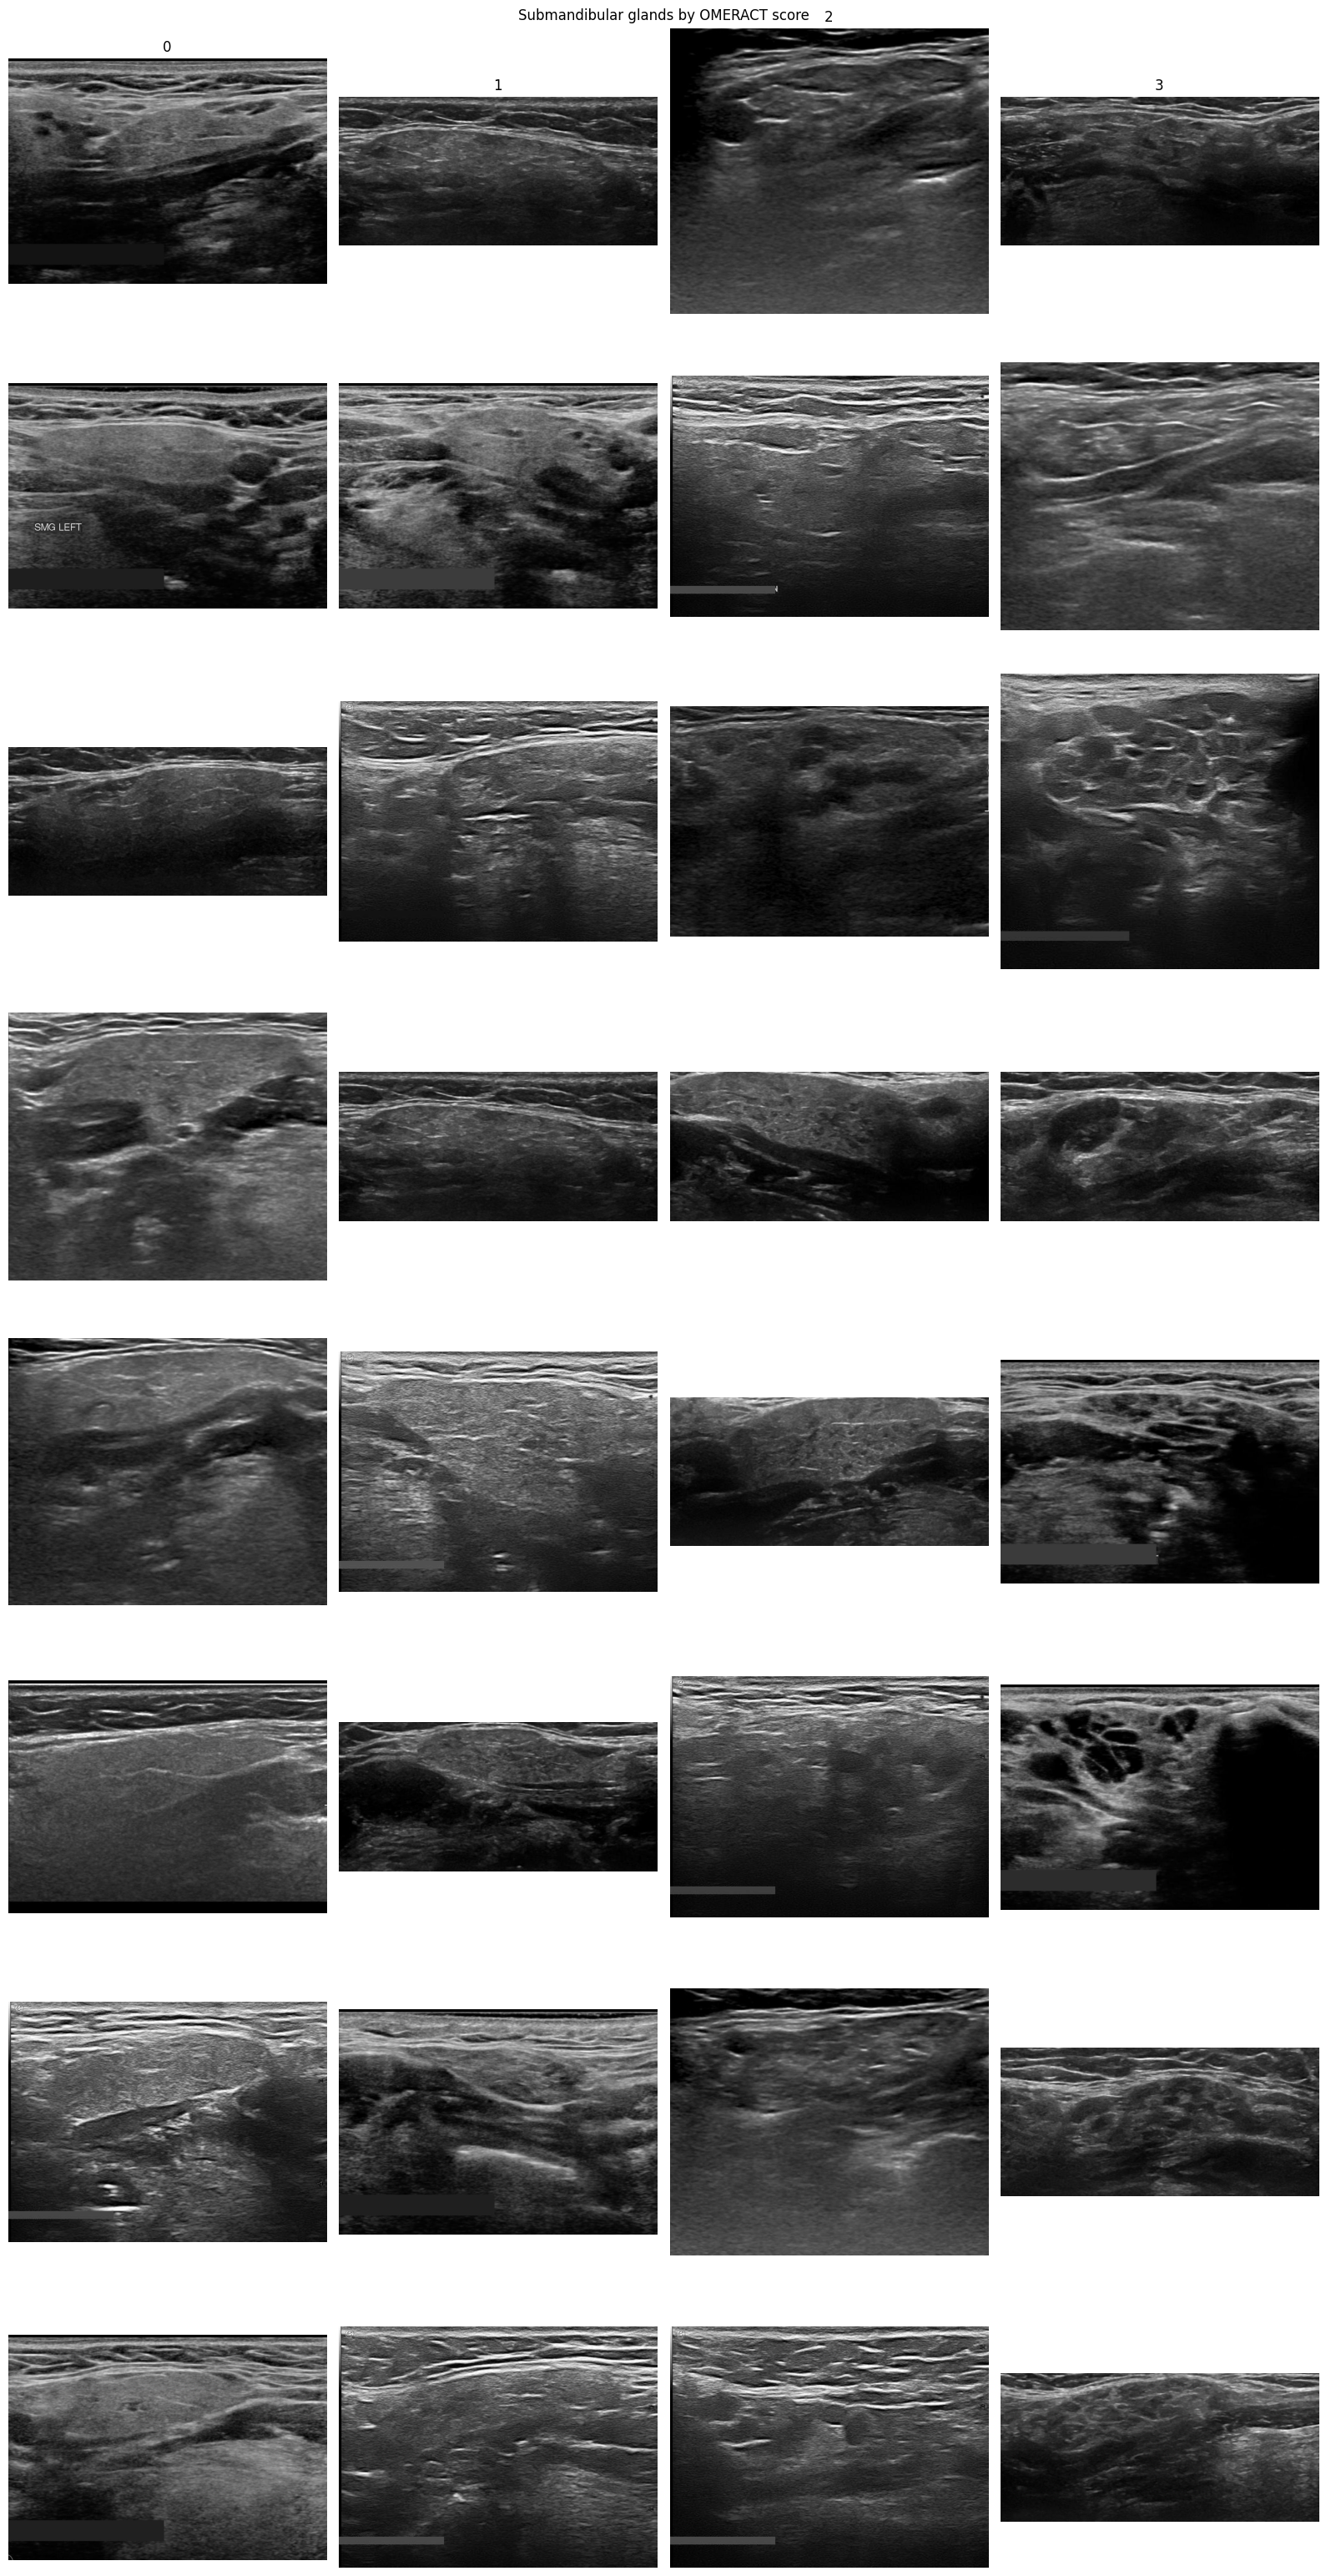

In [6]:
n, m = 4, 8
split_key = 'OMERACT score'
values = [0, 1, 2, 3]
filter = True
filter_key = 'parotid/submandibular'
filter_value = 'submandibular'
title = 'Submandibular glands by OMERACT score'

plot_grid(m, n, split_key, values, filter, filter_key, filter_value, title)

In [62]:
from src.data.datasets import CachedImageDataset, CustomImageDataset
from src.data.preprocessing import *
from torchvision.transforms import v2
from src.data.split import data_split

train_transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.RandomHorizontalFlip(p=0.5),

    RandomCropHorizontal(),
    AutoContrast(),
    v2.RandomRotation(
              (-config.data.rotation_angle, config.data.rotation_angle),
             v2.InterpolationMode.BILINEAR),
    v2.Resize(config.data.crop_size),
    # v2.GaussianBlur(kernel_size = 3),
    # v2.ColorJitter(),
    v2.Normalize([0.25176433, 0.25176433, 0.25176433], [0.1612002, 0.1612002, 0.1612002])
    # v2.RandomEqualize(p = 0.5),
])


valid_transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    CropCenterHorizontal(),
    AutoContrast(),
    v2.Resize(config.data.crop_size),
    v2.Normalize([0.25176433, 0.25176433, 0.25176433], [0.1612002, 0.1612002, 0.1612002])
])

train_data, val_data, test_data = data_split(random_state=42)
im_train, y_train = train_data
im_val, y_val = val_data
im_test, y_test = test_data

train_dataset = CustomImageDataset(im_train, y_train, train_transform)
valid_dataset = CustomImageDataset(im_val, y_val, valid_transform)
test_dataset = CustomImageDataset(im_test, y_test, None)


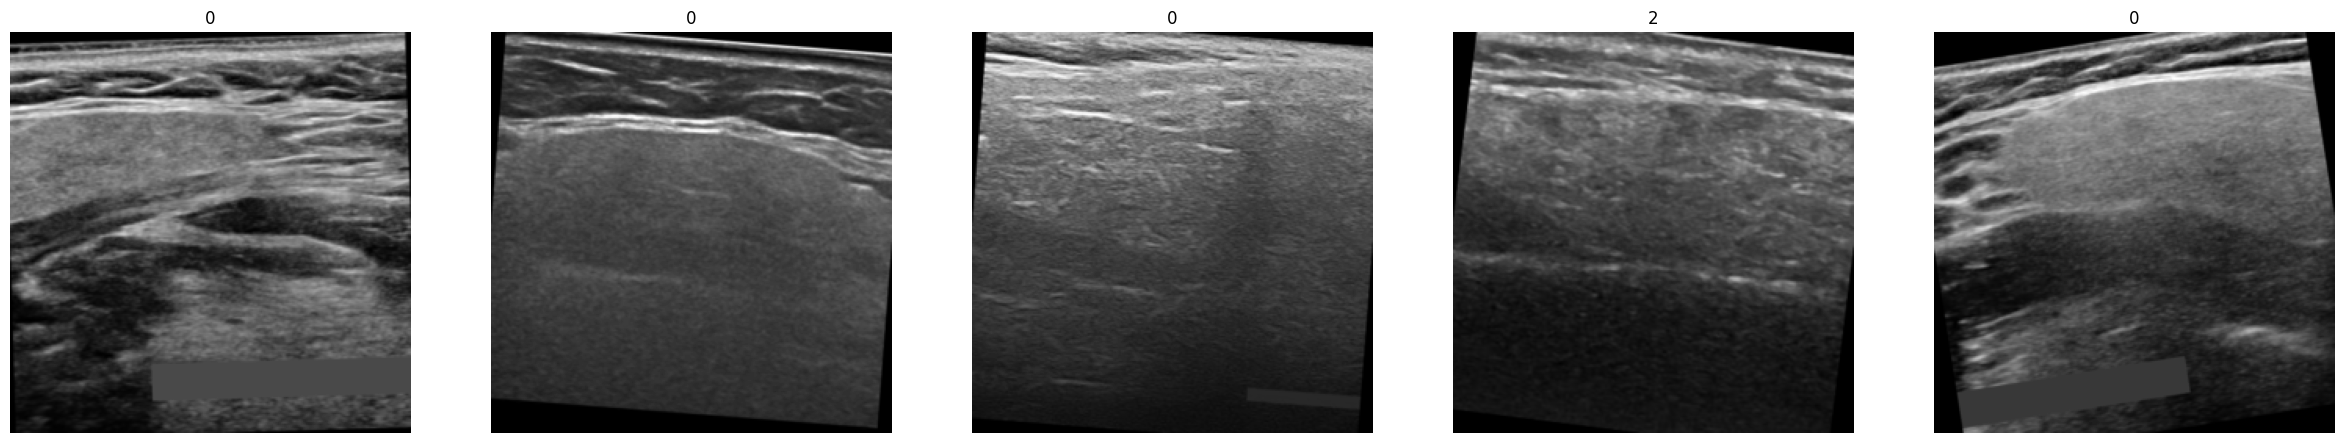

In [64]:
import matplotlib.pyplot as plt
import numpy as np

n = 5

fig, axs = plt.subplots(1, n, figsize=(6*n, 6))

for ax in axs:
    img, label = train_dataset[np.random.randint(len(train_dataset))]
    ax.imshow(img.numpy()[0], 'gray')
    ax.axis(False)
    ax.set_title(int(label.item()))
plt.show()